# PART A. ScVelo Pipeline

## 1. LOAD IN LIBRARIES

In [1]:
#%matplotlib notebook
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata as ad
import cellrank as cr
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

## 2. LOAD IN DATA

### Required input

1. count matrix
2. pca loadings
3. pca coordinates/embeddings
4. umap coordinates/embeddings
5. cluster annotations
6. .loom file generated from velocyto pipeline
7. (optional) cell cycle scores

All your input matrix should be in the format of cell barcode in the first column, and their corresponding data as other columns (umap embeddings, pca coordinates, etc)

The input was extracted from the seurat_obj (wat_cc_ and bat_cc) with the following commands:

In [2]:
# Load the Seurat-exported data
normalized_counts = pd.read_csv('F:/new_analysis/updated_scvelo/bat/regressed/normalized_counts.csv', index_col=0)  # Normalized data (genes x cells)
pca_embeddings = pd.read_csv('F:/new_analysis/updated_scvelo/bat/regressed/pca_embeddings.csv', index_col=0)  # PCA embeddings
umap_embeddings = pd.read_csv('F:/new_analysis/updated_scvelo/bat/regressed/umap_embeddings.csv', index_col=0)  # UMAP embeddings
clusters = pd.read_csv('F:/new_analysis/updated_scvelo/bat/regressed/clusters.csv', index_col=0)  # Cluster labels
cell_cycle_scores = pd.read_csv('F:/new_analysis/updated_scvelo/bat/regressed/cell_cycle_scores.csv', index_col=0)  # Cell cycle scores (optional)

# Create an AnnData object using normalized counts (transpose because AnnData expects cells as rows)
adata = ad.AnnData(normalized_counts.T)  # Transpose because AnnData expects cells as rows

# Store the normalized counts in the 'raw' attribute (important for downstream differential expression analysis)
adata.raw = adata

# Add PCA and UMAP embeddings as 'obsm' (multi-dimensional annotations for cells)
adata.obsm['X_pca'] = pca_embeddings.values  # Add PCA embeddings to 'obsm'
adata.obsm['X_umap'] = umap_embeddings.values  # Add UMAP embeddings to 'obsm'

# Add cluster labels as 'obs' (observations, corresponding to cells)
adata.obs['bat_clusters'] = clusters['x']

# Add cell cycle scores as 'obs' (optional)
adata.obs['S_score'] = cell_cycle_scores['S_score']
adata.obs['G2M_score'] = cell_cycle_scores['G2M_score']

vel=scv.read('F:/new_analysis/0BAT/velocyto/0BAT.loom', cache=True)

In [3]:
color_dict = {
    'W1': '#00cd66',
    'W2': '#fcd589',
    'W3': '#cd6600',
    'W4': '#ff3030',
    'wCAPs': '#8c510a',
    'wFAPLs': '#5ab4ac',
    'Differentiating wFAPLs': '#01665e',
    'dwFAPLs':'#01665e',
    'Diff wFAPLs' : '#01665e',     'B1': '#00868b',
    'B2': '#cd5b45',
    'B3': '#FFE300',
    'B4': '#00BFFF',
    'B5': '#00FFFF',
    'bCAPs': '#0000FF',
    'bFAPLs' : '#FF0000'
}

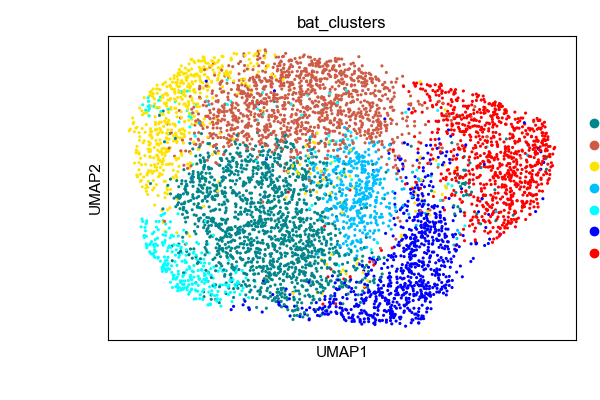

In [4]:
sc.pl.umap(adata, color='bat_clusters',palette=color_dict)

### Merge splice and unspliced counts (velocyto output)

In [6]:
adata= scv.utils.merge(adata, vel)
print('spliced/unspliced merged')

spliced/unspliced merged


## 3. RUN SCVELO

In [ ]:
#sc.pp.pca(adata, n_comps=50)

In [7]:
#sc.pp.neighbors(adata, use_rep='X_pca')
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

#recover dynamics, this step takes the longest ~30-50 mins if n_jobs not clarified. if n_jobs=4 it takes less than 30 mins
scv.tl.recover_dynamics(adata, n_jobs=4)




Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 4/4 cores)


  0%|          | 0/2544 [00:00<?, ?gene/s]

    finished (0:17:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


#### Compute RNA velocity 

In [8]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata, n_jobs=4)
scv.tl.recover_latent_time(adata)

computing velocities
    finished (0:00:30) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 4/4 cores)


  0%|          | 0/5958 [00:00<?, ?cells/s]

    finished (0:01:43) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:20) --> added 
    'latent_time', shared time (adata.obs)


## 4. Generating plots

#### Overall UMAP with direction

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


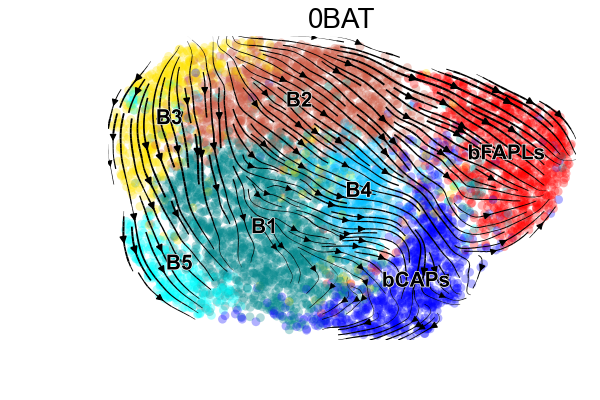

In [10]:

warnings.filterwarnings("ignore", category=DeprecationWarning)
#%matplotlib inline

scv.pl.velocity_embedding_stream(adata,basis="umap",color="bat_clusters",palette=color_dict, title='0BAT',fontsize=20,legend_fontsize=15,min_mass=2)
#scv.pl.velocity_embedding_stream(adata, color= 'seurat_clusters')


#### Fig EV4A. Directionality colored by latent time labeling

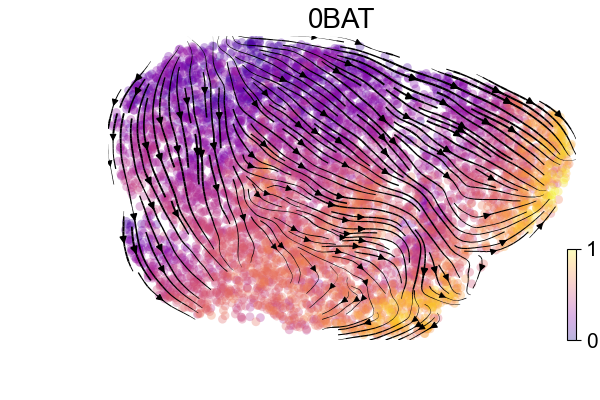

In [11]:
scv.pl.velocity_embedding_stream(adata,basis="umap",color="latent_time",title='0BAT',fontsize=20,legend_fontsize=15,min_mass=2,color_map="plasma")


# PART B. CellRank pipeline

## 1. Create velocity kernel


In [12]:
vk = cr.kernels.VelocityKernel(adata)


## 2. Compute transition matrix


In [13]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/5958 [00:00<?, ?cell/s]

Using `softmax_scale=2.4907`


  0%|          | 0/5958 [00:00<?, ?cell/s]

    Finish (0:01:01)


VelocityKernel[n=5958, model='deterministic', similarity='correlation', softmax_scale=2.491]

## 3. Run CellRank GPCCA estimator


Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10, 15, 18]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:01:47)


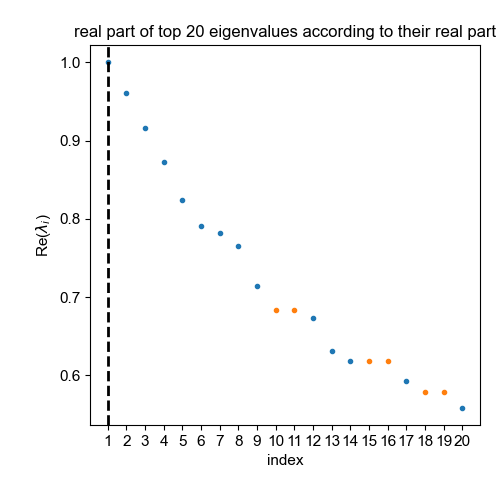

In [14]:
g2 = cr.estimators.GPCCA(vk)
g2.compute_schur()
g2.plot_spectrum(real_only=True)

## 4. Compute macrostate


#### Fig. 3A - Macrostates

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)


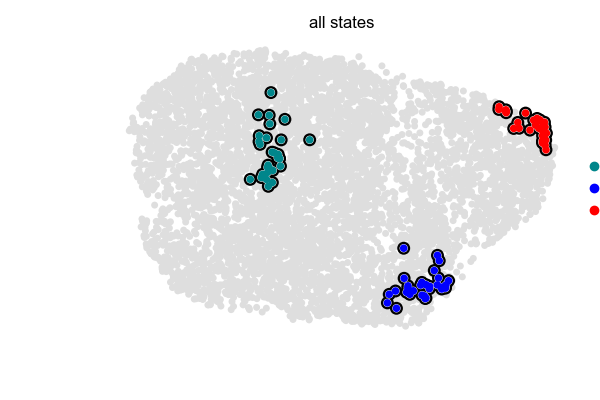

In [15]:
#%matplotlib inline
g2.compute_macrostates(n_states=3, cluster_key="bat_clusters", n_cells=30)
g2.plot_macrostates(which="all", legend_loc="right", s=100)
pl.tight_layout()

#### Fig. EV4B Macrostate composisions

C:\Users\bouncybear223\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


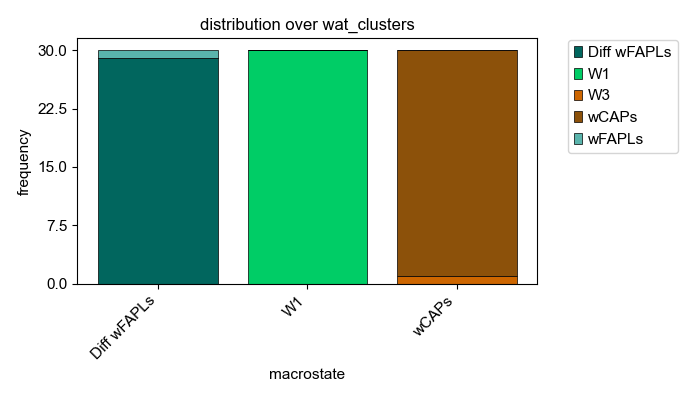

In [14]:
g2.plot_macrostate_composition(key="bat_clusters", figsize=(7, 4))

#### Fig. EV4C - coarse-grained transition matrix


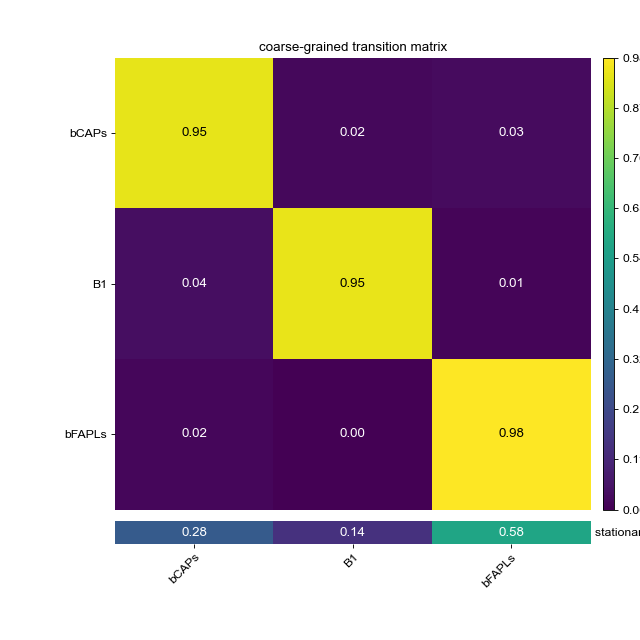

In [16]:
g2.plot_coarse_T(annotate=True)

#### Fig. 3A right - terminal and initial states

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


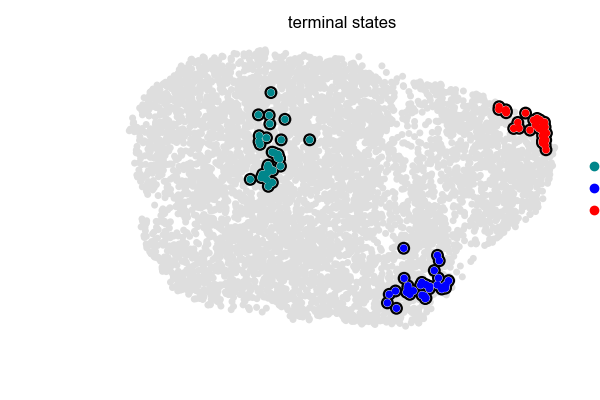

In [17]:
#g2.predict_terminal_states()
g2.predict_terminal_states(stability_threshold=0.94, allow_overlap=True)
g2.plot_macrostates(which="terminal", legend_loc="right", s=100)
#pl.tight_layout()

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


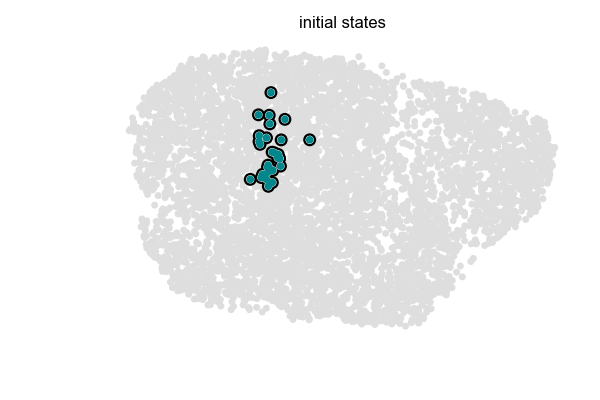

In [18]:
g2.predict_initial_states(allow_overlap=True)
g2.plot_macrostates(which="initial", s=100, legend_loc='none')
#g2.plot_macrostates(which="all", states=["W1"], legend_loc=None)

## 5. Estimate Cellular fate bias


Computing fate probabilities


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


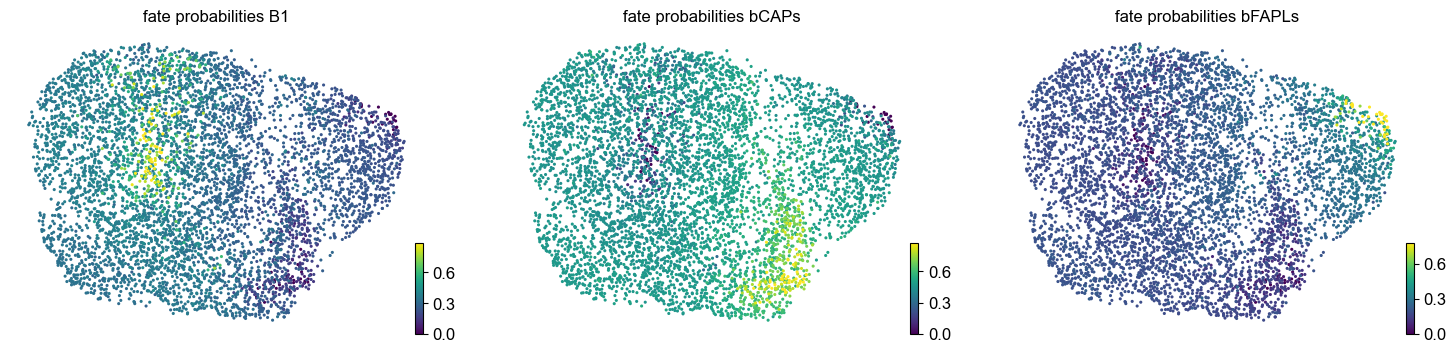

In [20]:
%matplotlib inline
g2.compute_fate_probabilities()
g2.plot_fate_probabilities(same_plot=False)


#### Fig. 3B fate probability 

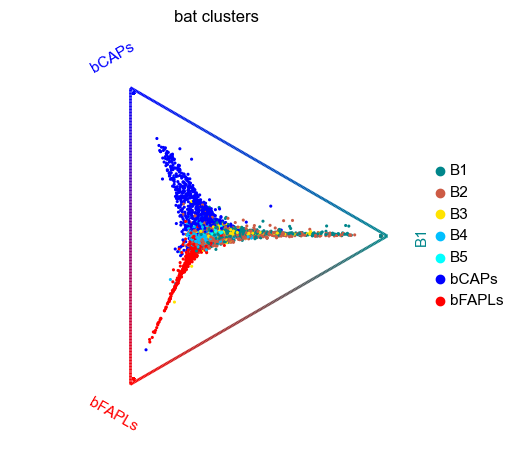

In [21]:
cr.pl.circular_projection(adata, keys='bat_clusters', legend_loc="right")
pl.tight_layout()

### calculate fate drivers

#### Run GPCCA model

In [22]:
model = cr.models.GAM(adata, n_knots=6)

#### Compute driver genes

In [23]:
bfapls_drivers = g2.compute_lineage_drivers(lineages=["bFAPLs"], cluster_key="bat_clusters")
bcaps_drivers = g2.compute_lineage_drivers(lineages=["bCAPs"], cluster_key="bat_clusters")
bcaps_genes= bcaps_drivers[(bcaps_drivers['bCAPs_qval'] < 0.05) & (bcaps_drivers['bCAPs_corr'] > 0)].index.tolist()
bfapls_genes= bfapls_drivers[(bfapls_drivers['bFAPLs_qval']< 0.05)& (bfapls_drivers['bFAPLs_corr'] > 0)].index.tolist()

len(bcaps_genes) #should be 3589
len(bfapls_genes) #should be 2261

genes_of_interest= bcaps_genes+bfapls_genes


Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:11)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)


2261

althernatively, if cannot reproduce, load in the saved driver genes

In [ ]:
filepath= "F:/new_analysis/updated_scvelo/requests/2025-05-24 cellrank heatmaps filtered by logq/"
bcaps_drivers= pd.read_csv(filepath+"bcaps_drivers.csv", header=None)
bfapls_drivers= pd.read_csv(filepath+"bfapls_drivers.csv",header=None)
wcaps_drivers= pd.read_csv(filepath+"wcaps_drivers.csv",header=None)
dwfapls_drivers= pd.read_csv(filepath+"dwfapls_drivers.csv",header=None)

bcaps_genes=bcaps_drivers[0].tolist()
bfapls_genes=bfapls_drivers[0].tolist()

len(bcaps_genes) #should be 3589
len(bfapls_genes) #should be 2261

genes_of_interest= bcaps_genes+bfapls_genes


In [25]:
genes_of_interest= bcaps_genes+bfapls_genes
#remove duplicates
genes_of_interest = list(set(genes_of_interest)) #this seems to work without doing the duplicate handling 

#### Table EV4- bCAPs and bFAPLs driver lists

In [ ]:
bfapls_drivers.to_csv("bFAPLs_Drivers.csv")
bcaps_drivers.to_csv("bCAPs_Drivers.csv")

#### run the temporal gene expression model

Computing trends using `1` core(s)


  0%|          | 0/5286 [00:00<?, ?gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not conver

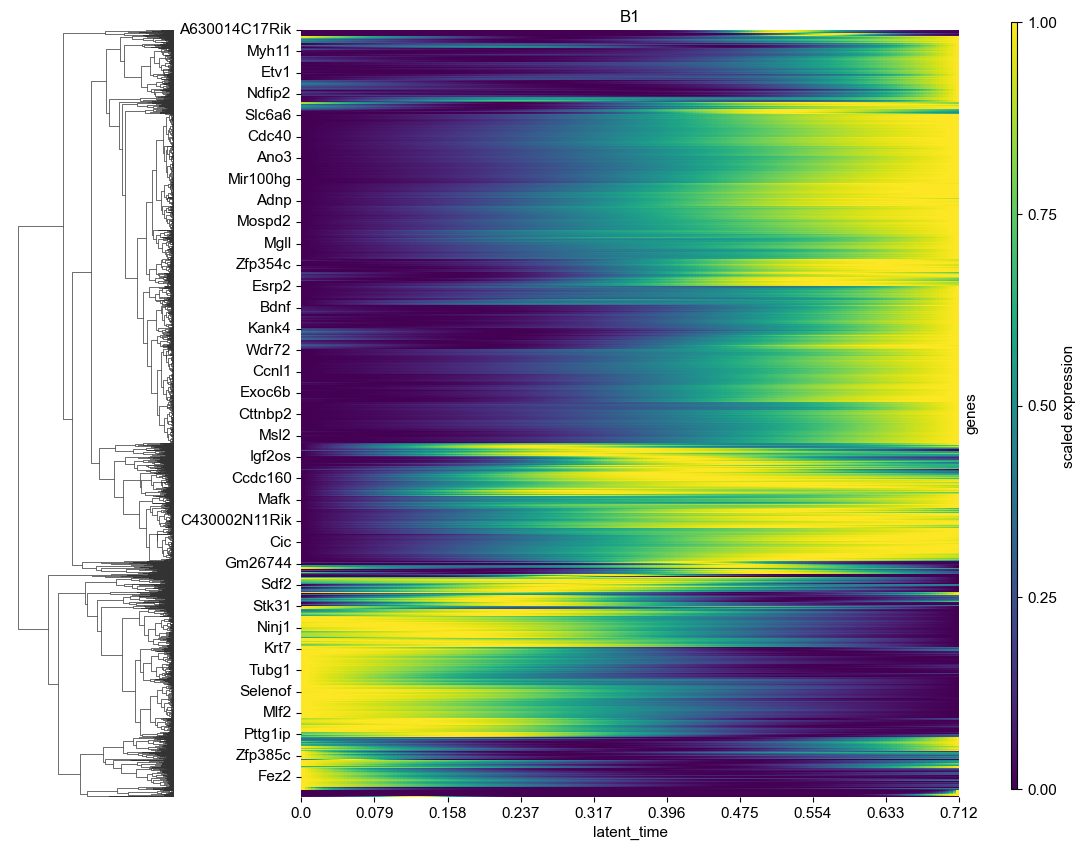

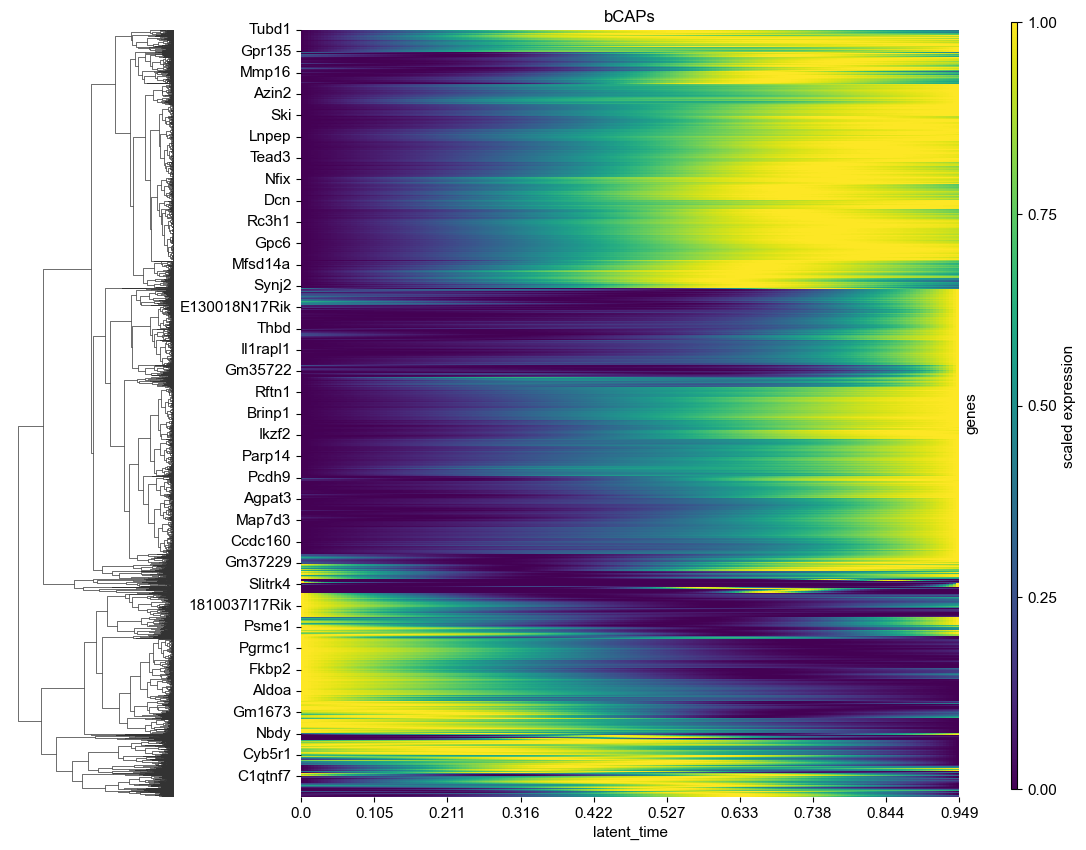

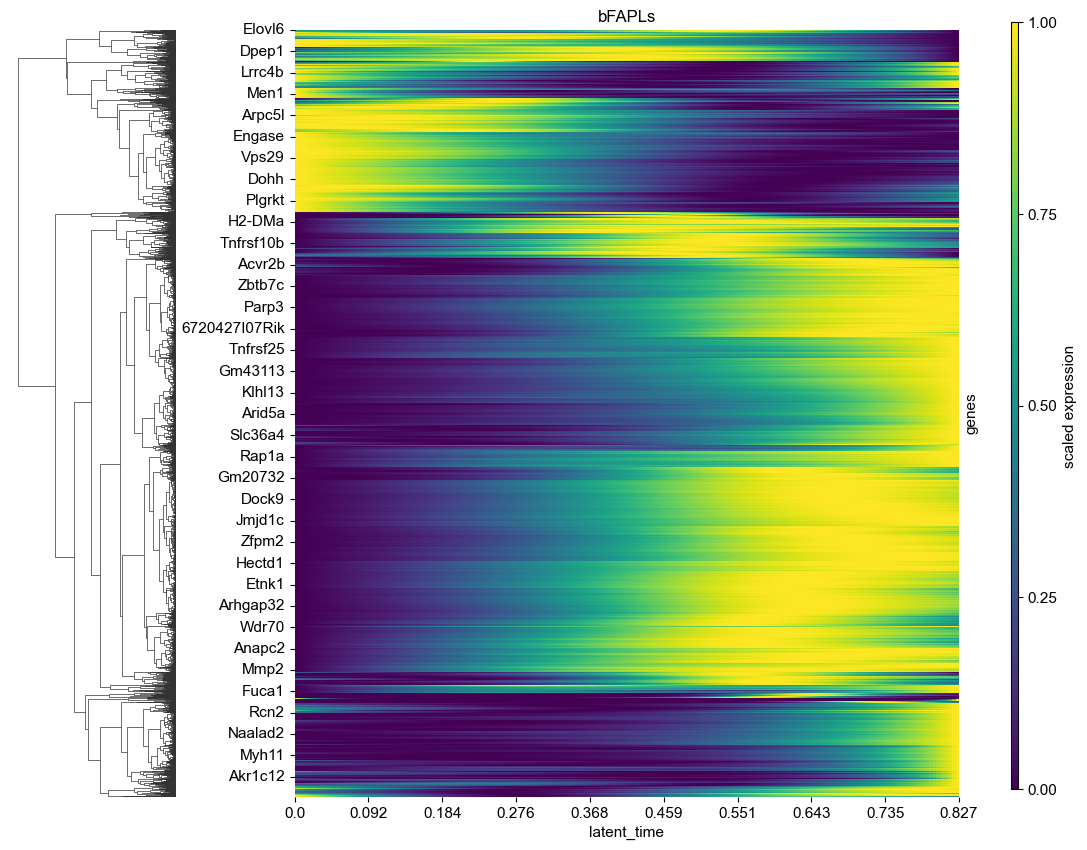

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import cellrank.pl as cr_pl
import matplotlib.pyplot as plt
all_models = cr.pl.heatmap(
    adata,
    model=model,
    genes=genes_of_interest,
    time_key="latent_time",
    mode="lineages",
    cluster_genes=True,
    return_models=True,
)


#### Reconstruct cr.pl.heatmap with bifurcation plotting

In [28]:
##############################################################################
# A)  Define each lineage's real endpoint
#     e.g. "Diff wFAPLs" domain ~ 0 -> 0.85 and "wCAPs" domain ~ 0 -> 0.40
##############################################################################
lineage_end_map = {
    "Diff wFAPLs": 0.859, "wFAPLs": 0.859,
    "wCAPs": 0.406,
    'bCAPs': 0.949,
    'bFAPLs': 0.827
}


##############################################################################
# Set a flag to decide whether to use scaled time (0–1) or raw time (0–endpoint)
##############################################################################
use_scaled_time = True  # Set to False to use raw time directly

##############################################################################
# B)  Modified safe_extract_predictions_for_lineage with a scaled time flag
##############################################################################
def safe_extract_predictions_for_lineage(all_models, lineage_name, gene_list, n_points=100, use_scaled_time=True):
    """
    Create a time grid based on the use_scaled_time flag.
      - If True, generate a scaled grid [0, 1] and map it to real time.
      - If False, generate a raw time grid [0, lineage_end_map[lineage_name]] directly.
    Then predict gene expression using the corresponding real time values.
    """
    max_t = lineage_end_map[lineage_name]
    if use_scaled_time:
        # Scaled grid: time values from 0 to 1
        grid = np.linspace(0, 1, n_points)
        # Map to the real time domain
        real_time = grid * max_t
    else:
        # Directly use a raw time grid: 0 to max_t
        grid = np.linspace(0, max_t, n_points)
        real_time = grid

    rows = []
    valid_genes = []
    for gene in gene_list:
        model_obj = all_models[gene].get(lineage_name, None)
        if model_obj is None or model_obj.__class__.__name__ == "FailedModel":
            continue
        y_pred = model_obj.predict(real_time.reshape(-1, 1))
        if y_pred.shape[0] != len(real_time):
            continue
        rows.append(y_pred)
        valid_genes.append(gene)

    mat = np.vstack(rows)
    # Use grid values for column names so that they represent either scaled or raw time
    colnames = [f"{lineage_name}_t{t:.2f}" for t in grid]
    df = pd.DataFrame(mat, index=valid_genes, columns=colnames)
    return df, grid

##############################################################################
# C)  Build DataFrames for both lineages using the chosen time type
##############################################################################
fateA='bFAPLs'
fateB='bCAPs'

df_fateA, gridA = safe_extract_predictions_for_lineage(all_models, fateA, genes_of_interest, use_scaled_time=use_scaled_time)
df_fateB, gridB = safe_extract_predictions_for_lineage(all_models, fateB, genes_of_interest, use_scaled_time=use_scaled_time)

##############################################################################
# D)  Reverse columns for Fate A (descending order) and order Fate B in ascending order.
##############################################################################
a_cols_sorted = sorted(df_fateA.columns, key=lambda c: float(c.split("_t")[-1]), reverse=True)
b_cols_sorted = sorted(df_fateB.columns, key=lambda c: float(c.split("_t")[-1]), reverse=False)

df_combined = pd.concat([df_fateA[a_cols_sorted], df_fateB[b_cols_sorted]], axis=1)

##############################################################################
# E)  Clean up Inf/NaN values and scale rows (min–max normalization)
##############################################################################
df_combined = df_combined.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

df_scaled = df_combined.copy()
from numpy import isclose

for gene in df_scaled.index:
    vals = df_scaled.loc[gene].values
    min_v, max_v = vals.min(), vals.max()
    if isclose(min_v, max_v):
        df_scaled.drop(gene, axis=0, inplace=True)
    else:
        df_scaled.loc[gene] = (vals - min_v) / (max_v - min_v + 1e-9)

##############################################################################
# F)  Build the color bar: determine cluster colors by converting the time value to real time
##############################################################################
cluster_col='bat_clusters' #for wat 
#cluster_col='bat_clusters' #for bat
def dominant_cluster_color(time_val, lineage_str, use_scaled_time=True, eps=0.02):
    """
    Determine the dominant cluster color based on a small time window around the given time value.
      - If use_scaled_time is True, convert the scaled time to raw time using lineage_end_map.
      - If False, time_val is already in raw units.
    """
    
    if use_scaled_time:
        max_t = lineage_end_map[lineage_str]
        real_time_val = time_val * max_t
    else:
        real_time_val = time_val

    time_low = real_time_val - eps
    time_high = real_time_val + eps

    subset_idx = adata.obs.index[
        (adata.obs["latent_time"] >= time_low) &
        (adata.obs["latent_time"] <= time_high)
    ]
    if len(subset_idx) == 0:
        return "lightgray"

    sub_clusters = adata.obs[cluster_col].loc[subset_idx]
    if len(sub_clusters) == 0:
        return "lightgray"

    top_cluster = sub_clusters.value_counts().idxmax()
    return color_dict.get(top_cluster, "lightgray")

##############################################################################
# G)  For each column in df_combined, parse the time value and assign a cluster color.
##############################################################################
col_colors = []
for col in df_combined.columns:
    # Column name format: "Lineage_tX.XX", where X.XX is either scaled or raw time
    lineage_str, t_str = col.split("_t")
    time_val = float(t_str)
    c = dominant_cluster_color(time_val, lineage_str, use_scaled_time=use_scaled_time)
    col_colors.append(c)




#### Fig. 3C - Temporal expression of driver genes

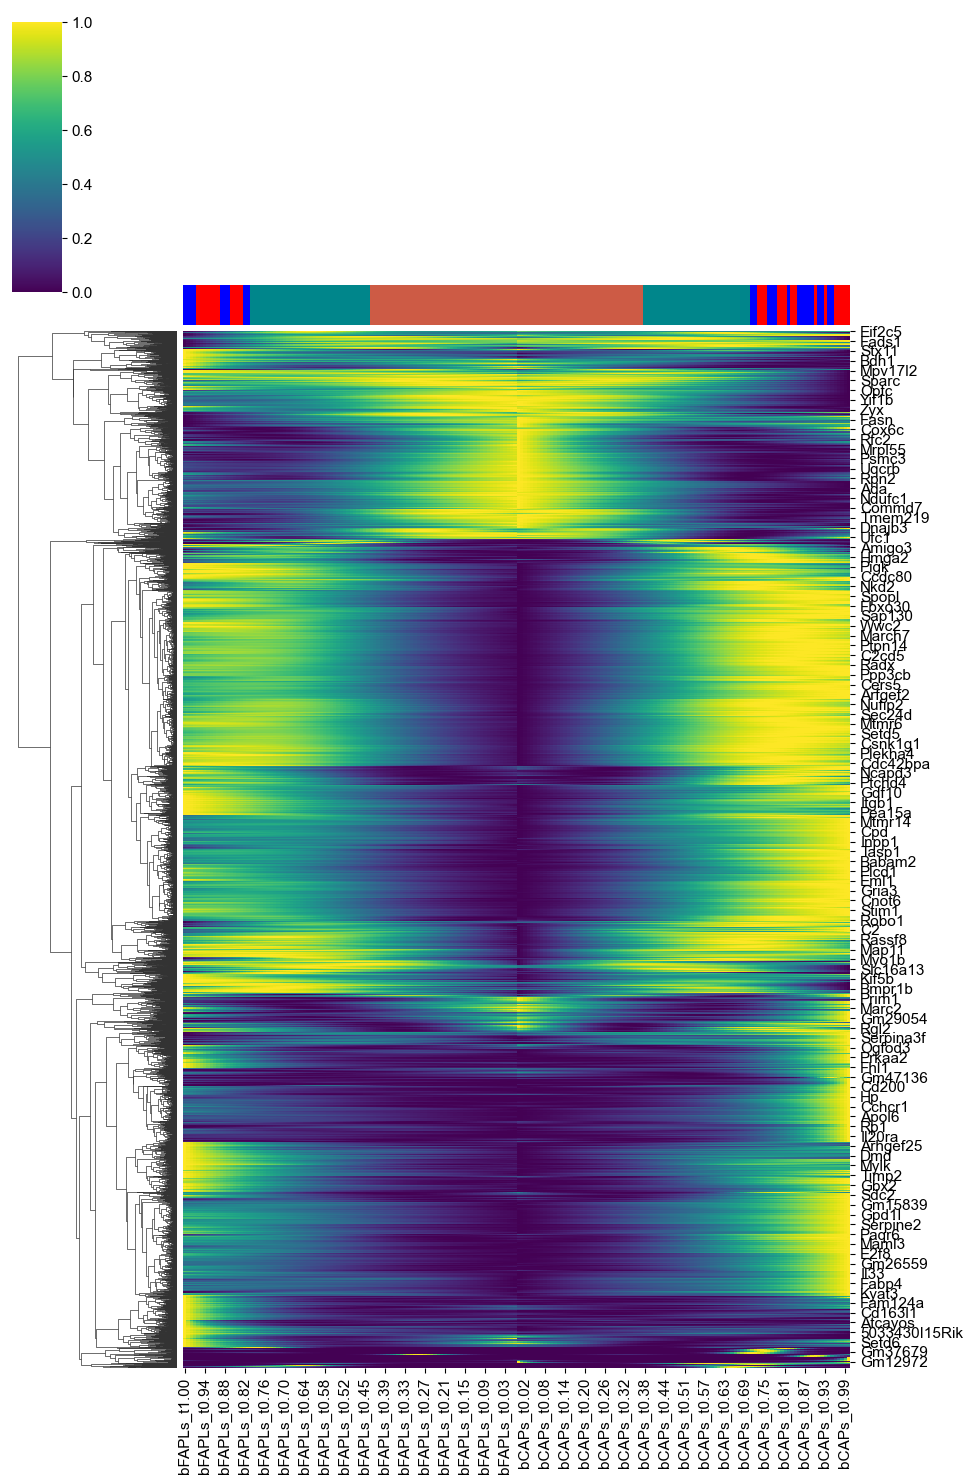

In [29]:
g = sns.clustermap(
        df_scaled,
        cmap="viridis",
        row_cluster=True,   # keep this if you still want clustering
        col_cluster=False,
        figsize=(10, 15),
        vmin=0, vmax=1,
        col_colors=col_colors,
        yticklabels=True     # leave True so labels are created
)

# --------- NEW: hide all but every 50th gene name ----------
ax = g.ax_heatmap                       # the main heat-map axis
step = 50                               # decide how sparse you want labels
yticks   = ax.get_yticks()              # numeric tick positions
ynames   = [t.get_text() for t in ax.get_yticklabels()]

# keep only every `step`-th tick/label
keep_idx = np.arange(0, len(ynames), step)
ax.set_yticks(yticks[keep_idx])
ax.set_yticklabels([ynames[i] for i in keep_idx])

plt.show()